# Cross Analysis

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [5]:
MOTION_CSV = "../data/motion.csv"
SIGNAL_CSV = "../data/signal.csv"
TARGET_BLE = '50:d0:9a:e3:43:6a'

In [8]:
motion_df = pd.read_csv(MOTION_CSV)
signal_df = pd.read_csv(SIGNAL_CSV)

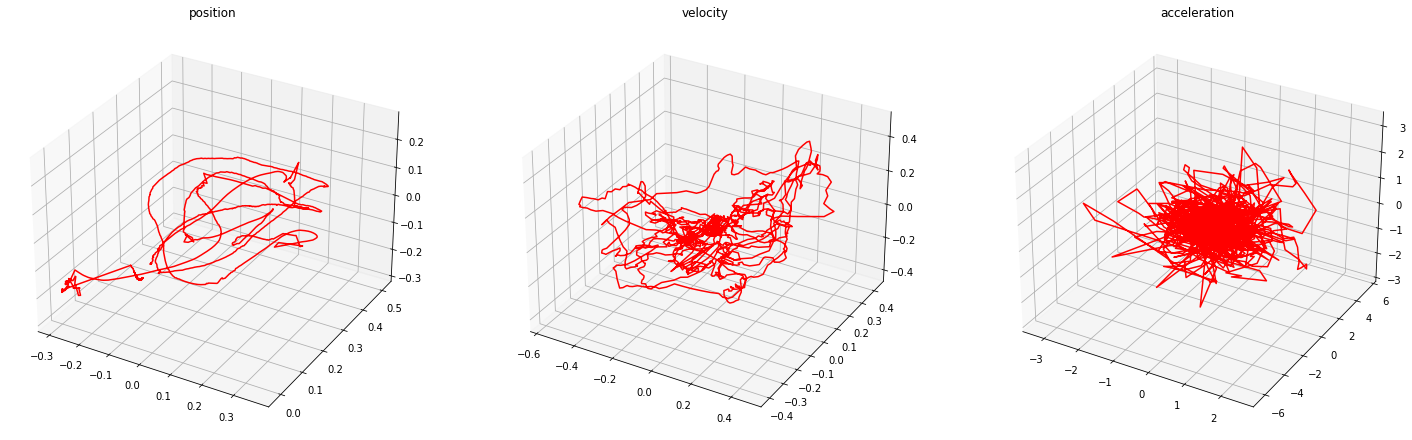

In [10]:
def plot_motion(df):
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot3D(df.x, df.y, df.z, 'red')
    ax.set_title('position')
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.set_title('velocity')
    ax.plot3D(df.vx, df.vy, df.vz, 'red')
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.set_title('acceleration')
    ax.plot3D(df.ax, df.ay, df.az, 'red')
    plt.show()
plot_motion(motion_df)

### The Time Gap between Two Measurement

In [34]:
def plot_time_diff(df,figsize=(25,5)):
    diff = df[['timestamp']].diff()[1:]
    plt.figure(figsize=figsize)
    plt.scatter(diff.index,diff, s=2)
    plt.title("capture time difference over time")
    plt.ylabel('Timestamp Difference (ms)')
    plt.show()

##### Time Gap between Two Motion Measurement

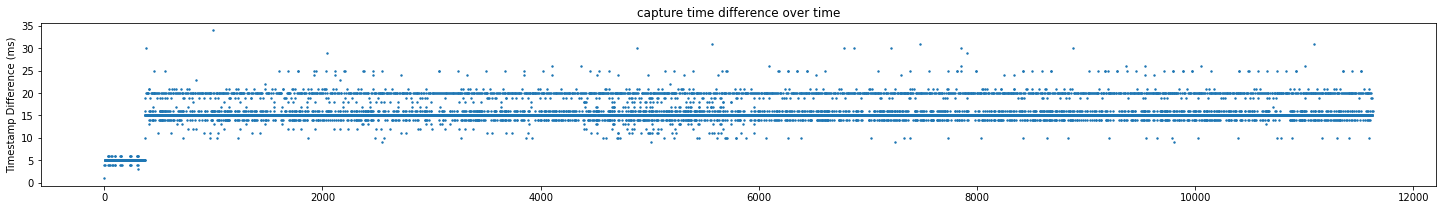

In [35]:
plot_time_diff(motion_df, figsize=(25,3))

##### Time Gap between Two Arbitrary Neighbour Signal

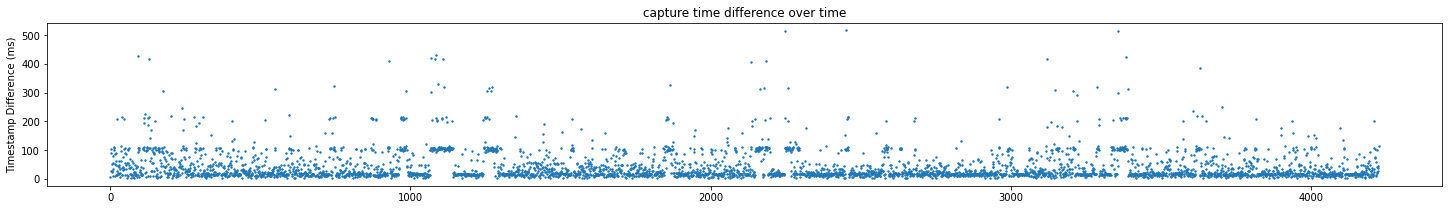

In [32]:
plot_time_diff(signal_df[['timestamp']], figsize=(25,3))

##### Time Gap between Two Target Neighbour Signal

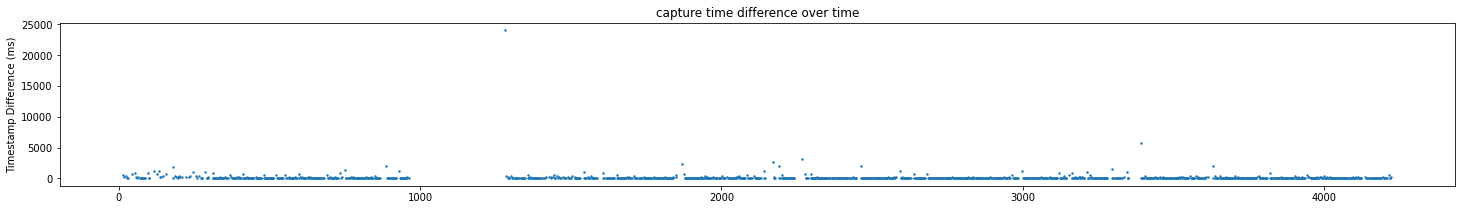

In [38]:
plot_time_diff(signal_df[signal_df['address']==TARGET_BLE][['timestamp']], figsize=(25,3))

### Concate Measurement

As T265 has much higher sampling speed, we can concate the measurement based on the t264 timeline. However this will lost many measurement we need. Therefore we use timeline based on signal.

Algorithm:
1. For each sample from T265 match to the most present signal measurement 

In [132]:
match_df = signal_df.copy()
cols = ['x','y','z','vx','vy','vz','ax','ay','az']

for col in cols:
    match_df[col] = np.nan
match_df['instantaneity'] = np.nan

In [133]:
for index, row in match_df.iterrows():
    timestamp = row['timestamp']
    match = motion_df.iloc[(motion_df.timestamp-timestamp).abs().argsort()[:1]] 
    for col in cols:
        match_df.at[index,col] = match[col].values[0]
    match_df.at[index,'instantaneity'] = match.timestamp.values[0] - timestamp
    clear_output(wait=True)
    print(f'{index}/{len(match_df.index)}')

4225/4226


##### Evaluate Matching Quality

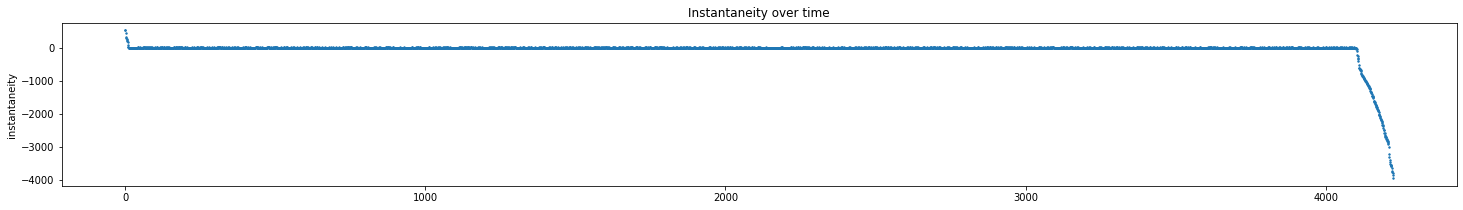

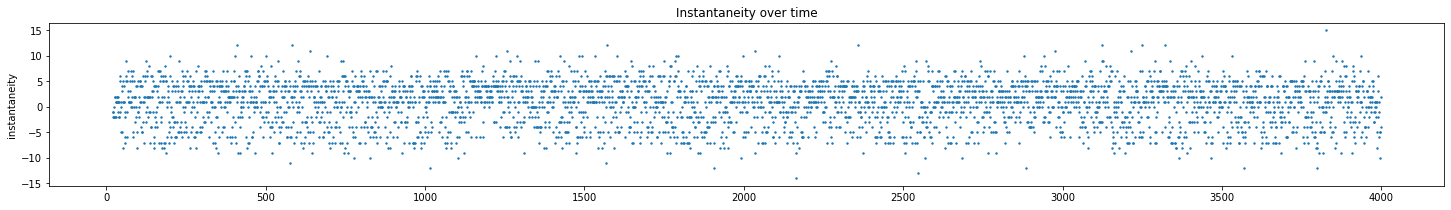

In [134]:
def plot_instantaneity(df,figsize=(25,3)):
    plt.figure(figsize=figsize)
    plt.scatter(df.index,df['instantaneity'], s=2)
    plt.title("Instantaneity over time")
    plt.ylabel('instantaneity')
    plt.show()
plot_instantaneity(match_df)
plot_instantaneity(match_df[20:4000])

In [135]:
df = match_df[20:4000]

### Visualize The Correlation

In [167]:
target_df = df[df['address'] == TARGET_BLE].drop(columns=['address'])

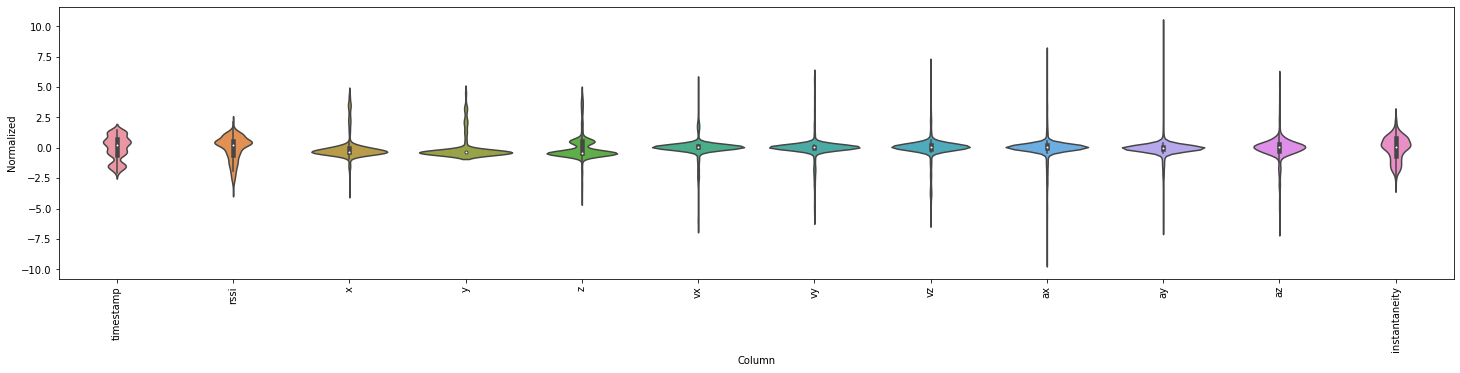

In [170]:
mean = target_df.mean()
std = target_df.std()
df_std = (target_df - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(25, 5))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(target_df.keys(), rotation=90)

### Analysis


* At the beginning, the fluctuation is caused by muving the transmitter. 
* Then the signal loss for unknown reason
* The signal fluctuated again due to moving the device
* At the end the device is placed on table

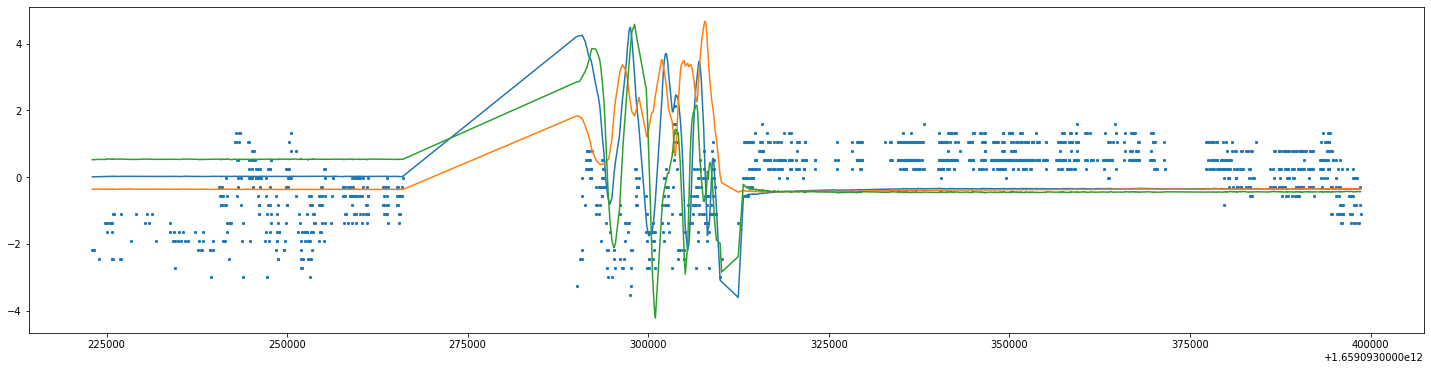

In [183]:
fig = plt.figure(figsize=(25,6))
plt.plot(target_df.timestamp, norm_df.x)
plt.plot(target_df.timestamp, norm_df.y)
plt.plot(target_df.timestamp, norm_df.z)
plt.scatter(target_df.timestamp, norm_df.rssi, s=5, marker='x')
plt.show()